### Student Information
Name:方竣平

Student ID: 113062617

GitHub ID: Billy152op

Kaggle name: team:FF,name:Chun-Ping Fang

Kaggle private scoreboard snapshot: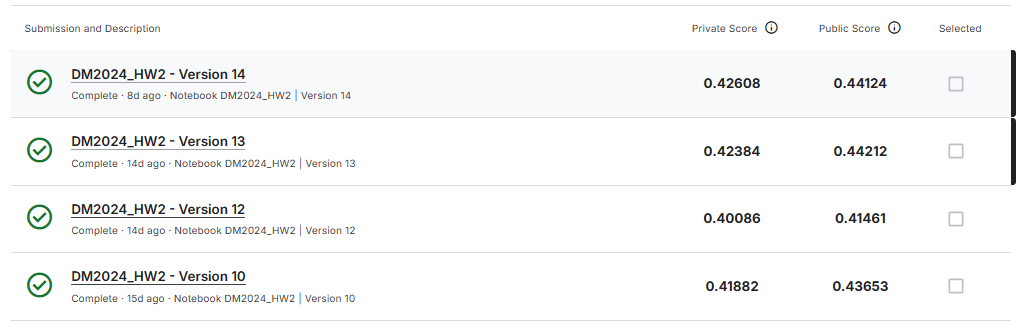

---

### Instructions

1. First: __This part is worth 30% of your grade.__ Do the **take home exercises** in the [DM2024-Lab2-master Repo](https://github.com/didiersalazar/DM2024-Lab2-Master). You may need to copy some cells from the Lab notebook to this notebook. 


2. Second: __This part is worth 30% of your grade.__ Participate in the in-class [Kaggle Competition](https://www.kaggle.com/competitions/dm-2024-isa-5810-lab-2-homework) regarding Emotion Recognition on Twitter by this link: https://www.kaggle.com/competitions/dm-2024-isa-5810-lab-2-homework. The scoring will be given according to your place in the Private Leaderboard ranking: 
    - **Bottom 40%**: Get 20% of the 30% available for this section.

    - **Top 41% - 100%**: Get (0.6N + 1 - x) / (0.6N) * 10 + 20 points, where N is the total number of participants, and x is your rank. (ie. If there are 100 participants and you rank 3rd your score will be (0.6 * 100 + 1 - 3) / (0.6 * 100) * 10 + 20 = 29.67% out of 30%.)   
    Submit your last submission **BEFORE the deadline (Nov. 26th, 11:59 pm, Tuesday)**. Make sure to take a screenshot of your position at the end of the competition and store it as '''pic0.png''' under the **img** folder of this repository and rerun the cell **Student Information**.
    

3. Third: __This part is worth 30% of your grade.__ A report of your work developing the model for the competition (You can use code and comment on it). This report should include what your preprocessing steps, the feature engineering steps and an explanation of your model. You can also mention different things you tried and insights you gained. 


4. Fourth: __This part is worth 10% of your grade.__ It's hard for us to follow if your code is messy :'(, so please **tidy up your notebook**.


Upload your files to your repository then submit the link to it on the corresponding e-learn assignment.

Make sure to commit and save your changes to your repository __BEFORE the deadline (Nov. 26th, 11:59 pm, Tuesday)__. 

### Begin Assignment Here
1. Used TfidfVectorizer with a maximum of 30,000 features to convert text into numerical representations. I found that using 5000 was not enough for this competition. I also tried CountVectorizer, but it will contain some unimportant words.
2. I used label encoding method from master to transform data into (,8)
3. DecisionTreeClassifier was not powerful, the result was awful.
4. So I used NN in this task. Originally, I added 4 hidden layer, but it turned out public score 0.4. I add more hidden layer and import early-stopping to prevent overfitting.
5. Maybe next time I will try using LLM to extract word's feature.

In [ ]:
import json
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, ReLU, Softmax, BatchNormalization
import keras

In [ ]:
data = []
with open('/kaggle/input/dm-2024-isa-5810-lab-2-homework/tweets_DM.json', 'r') as f:
    for line in f:
        data.append(json.loads(line))
 
f.close()

In [ ]:
emotion = pd.read_csv('/kaggle/input/dm-2024-isa-5810-lab-2-homework/emotion.csv')
data_identification = pd.read_csv('/kaggle/input/dm-2024-isa-5810-lab-2-homework/data_identification.csv')

In [ ]:
df = pd.DataFrame(data)
_source = df['_source'].apply(lambda x: x['tweet'])
df = pd.DataFrame({
    'tweet_id': _source.apply(lambda x: x['tweet_id']),
    'hashtags': _source.apply(lambda x: x['hashtags']),
    'text': _source.apply(lambda x: x['text']),
})
df = df.merge(data_identification, on='tweet_id', how='left')

train_df = df[df['identification'] == 'train']
test_df = df[df['identification'] == 'test']

In [ ]:
train_df = train_df.merge(emotion, on='tweet_id', how='left')
train_df.drop_duplicates(subset=['text'], keep=False, inplace=True)

In [ ]:
tfidf_vectorizer = TfidfVectorizer(max_features=30000, stop_words='english')
tfidf_vectorizer.fit(train_df['text'])

X_train = tfidf_vectorizer.transform(train_df['text'])
X_test = tfidf_vectorizer.transform(test_df['text'])
y_train = train_df['emotion']

# DT_model = DecisionTreeClassifier(random_state=1)

# ## training!
# DT_model = DT_model.fit(X_train, y_train)

# ## predict!
# y_pred = DT_model.predict(X_test)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

label_encoder = LabelEncoder()
label_encoder.fit(y_train)

def label_encode(le, labels):
    enc = le.transform(labels)
    return keras.utils.to_categorical(enc)

def label_decode(le, one_hot_label):
    dec = np.argmax(one_hot_label, axis=1)
    return le.inverse_transform(dec)

y_train = label_encode(label_encoder, y_train)
y_val = label_encode(label_encoder, y_val)

In [ ]:
# Input layer
model_input = Input(shape=(30000, ))

# First hidden layer
X = Dense(units=1024)(model_input)
X = BatchNormalization()(X)
X = ReLU()(X)
X = Dropout(0.3)(X)

# Second hidden layer
X = Dense(units=512)(X)
X = BatchNormalization()(X)
X = ReLU()(X)
X = Dropout(0.3)(X)

# Third hidden layer
X = Dense(units=256)(X)
X = BatchNormalization()(X)
X = ReLU()(X)
X = Dropout(0.3)(X)

# Fourth hidden layer
X = Dense(units=128)(X)
X = BatchNormalization()(X)
X = ReLU()(X)
X = Dropout(0.2)(X)

# Fifth hidden layer
X = Dense(units=64)(X)
X = BatchNormalization()(X)
X = ReLU()(X)
X = Dropout(0.1)(X)

# Sixth hidden layer
X = Dense(units=32)(X)
X = BatchNormalization()(X)
X = ReLU()(X)

# Output layer
model_output = Dense(units=8, activation='softmax')(X)

# Build the model
model = Model(inputs=[model_input], outputs=[model_output])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Model summary
model.summary()

In [ ]:
epochs = 25
batch_size = 256

from tensorflow.keras.callbacks import EarlyStopping

# use early-stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=8,
    mode='max',
    restore_best_weights=True
)

# training!
history = model.fit(
    X_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping] 
)

In [ ]:
y_pred = model.predict(X_test)
y_pred = label_decode(label_encoder, y_pred)

In [ ]:
submission = pd.DataFrame({
    'id': test_df['tweet_id'],
    'emotion': y_pred
})

In [ ]:
submission.to_csv('submission.csv', index=False)